68608000/68606236 [==============================] - 1s 0us/step
/root/.keras/datasets/cats_and_dogs_filtered
['validation', 'vectorize.py', 'train']
Training size:
Cats: 1000
Dogs: 1000
Validation size:
Cats: 500
Dogs: 500
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Co

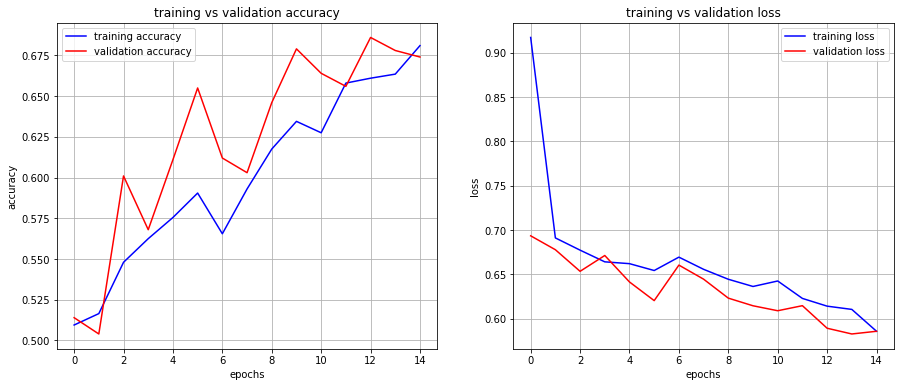

In [0]:
# TensorFlow Tutorials
# Image Classification
# https://www.tensorflow.org/tutorials/images/classification
# fit & fit_generator keras documentation: https://keras.io/models/sequential/#fit_generator
# https://medium.com/difference-engine-ai/keras-a-thing-you-should-know-about-keras-if-you-plan-to-train-a-deep-learning-model-on-a-large-fdd63ce66bd2



import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from datetime import *


starttime = datetime.now()


# Importing the image dataset
url = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=url, extract=True)
# path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=url, extract=False)
path = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')
print(path)
print(os.listdir(path))

# Dataset sizes:
train_dir = os.path.join(path, 'train')
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
print('Training size:')
print('Cats:',len(os.listdir(train_cats_dir)))
print('Dogs:',len(os.listdir(train_dogs_dir)))

val_dir = os.path.join(path, 'validation')
val_cats_dir = os.path.join(val_dir, 'cats')
val_dogs_dir = os.path.join(val_dir, 'dogs')
print('Validation size:')
print('Cats:',len(os.listdir(val_cats_dir)))
print('Dogs:',len(os.listdir(val_dogs_dir)))

# Image generator
img_size = 150
batch_size = 100

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Flow images in batches
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary'  # Since we use binary_crossentropy loss, we need binary labels
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary'  # Since we use binary_crossentropy loss, we need binary labels
)

# Model set-up
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(img_size, img_size, 3)),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPool2D(2, 2),
    # tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    # tf.keras.layers.MaxPool2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    # tf.keras.layers.Dense(512, activation='relu'),
    # tf.keras.layers.Dropout(0.5),
    # tf.keras.layers.Dense(512, activation='relu'),
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

from tensorflow.keras.optimizers import RMSprop
model.compile(
    optimizer = 'adam', # RMSprop(lr=0.001)   # Adam seems less noisy than RMSprop
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

# Callback
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        target=0.98
        if logs['accuracy']>target :
            print('Reached %0.2f%% training accuracy. Training converged!' %(target*100))
            self.model.stop_training = True
            
callback = myCallback()

# Train the model
# history = model.fit(
history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.n//train_generator.batch_size,
    callbacks = [callback],
    epochs = 15,
    validation_data = val_generator,
    validation_steps = val_generator.n//val_generator.batch_size,
    verbose = 1
)

# plotting results
accu = history.history['accuracy']
val_accu = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(accu, 'b', label='training accuracy')
plt.plot(val_accu, 'r', label='validation accuracy')
plt.legend()
plt.title('training vs validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid()

plt.subplot(1,2,2)
plt.plot(loss, 'b', label='training loss')
plt.plot(val_loss, 'r', label='validation loss')
plt.legend()
plt.title('training vs validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()



# Visualize training images
# Visualize the training images by extracting a batch of images from the training generator—which is 32 images in this example—then plot five of them with matplotlib.
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# The next function returns a batch from the dataset. The return value of next function is in form of (x_train, y_train) where x_train is training features and y_train, its labels. Discard the labels to only visualize the training images.
sample_training_images, _ = next(train_generator)

# plotImages(sample_training_images[:5])


# Take one sample image from the training examples and repeat it five times so that the augmentation is applied to the same image five times.
augmented_images = [train_generator[0][0][0] for i in range(5)]

# Re-use the same custom plotting function defined and used above to visualize the training images
# plotImages(augmented_images)



et1 = datetime.now() - starttime

print( '\n-> Elapsed execution time: %0.4f seconds.\n' %(et1.total_seconds()) )
